# Intelligibilité du modèle

In [1]:
import pandas as pd

In [2]:
import pandas as pd
df_c = pd.read_csv("../data/customers.csv", delimiter=";")
df_i = pd.read_csv("../data/indicators.csv", delimiter=";")
df = df_c.merge(df_i,on="ID_CLIENT")
df["DATE_ENTREE"]=pd.to_datetime(df["DATE_ENTREE"]) 

In [3]:
import datetime
df = df.assign(delta_date = lambda x: x.DATE_ENTREE - datetime.datetime(year = 2020, month = 6, day = 1))
df = df.assign(delta_date = lambda x: x.delta_date.dt.days)
df = df.assign(Balance_by_product = lambda x: x.BALANCE/x.NB_PRODUITS)

In [4]:
df = df.dropna()
data = df.drop(['DATE_ENTREE','ID_CLIENT', 'NOM', 'delta_date'], axis = 1)
X = data.drop(['CHURN'], axis = 1)
y = data['CHURN']
y = data["CHURN"].replace(to_replace=["Yes", "No"], value=[1,0])
numeric_features = X.select_dtypes(include =\
             ['float64']).columns.tolist()
categoric_features = X.select_dtypes(include =\
             ['object','int64']).columns.tolist()


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
            X,
            y,
            test_size=0.33, 
            random_state=42)

In [6]:
from scipy.sparse import csr_matrix 

In [7]:
X[['SEXE', 'MEMBRE_ACTIF']].values

array([['H', 'No'],
       ['H', 'Yes'],
       ['H', 'No'],
       ...,
       ['F', 'No'],
       ['F', 'Yes'],
       ['H', 'Yes']], dtype=object)

In [8]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9391 entries, 0 to 9949
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PAYS                9391 non-null   object 
 1   SEXE                9391 non-null   object 
 2   AGE                 9391 non-null   int64  
 3   MEMBRE_ACTIF        9391 non-null   object 
 4   BALANCE             9391 non-null   float64
 5   NB_PRODUITS         9391 non-null   int64  
 6   CARTE_CREDIT        9391 non-null   object 
 7   SALAIRE             9391 non-null   float64
 8   SCORE_CREDIT        9391 non-null   float64
 9   Balance_by_product  9391 non-null   float64
dtypes: float64(4), int64(2), object(4)
memory usage: 807.0+ KB


In [9]:
# Modifier le path pour qu'il corresponde 
import sys
sys.path.append('/home/javel/Documents/git_project/test/projet_ml_advanced_am_mv_rh/.venv/lib/python3.8/site-packages')
sys.path.append('/home/javel/Documents/git_project/test/projet_ml_advanced_am_mv_rh/')

In [10]:
from churn_predictor.domain.model_benchmark import PipelineBenchmark
bench = PipelineBenchmark(X_train, y_train)

The file flask_secret can't be found. It is required if you aim to run Churn Predictor web application and not only the notebooks. If needed, please run init.sh


In [11]:
bench.print_scores_of("Baseline classification")

Scores of Baseline classification
 - Churn_Cost: 14.64
 - Av_Prec: 0.68
 - ROC_AUC: 0.83
 - Recall: 0.38
 - Precision: 0.82


In [12]:
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier


In [91]:
!pip install imblearn

In [42]:
import imblearn

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

In [47]:
name = "Tuned_US_Adaboost"
clf = imbPipeline(steps=[
    ('Preprocessor', bench.base_transformer),
    ('Sampler', RandomUnderSampler(random_state=42)),
    ('classifier', AdaBoostClassifier(
        base_estimator=DecisionTreeClassifier(max_depth=3),
        algorithm='SAMME',
        n_estimators= 1000,
        learning_rate= 0.1,
    )),
])

In [90]:
clf.fit(X_train, y_train);

In [49]:
tran = clf['Preprocessor'].fit_transform(X_train,y_train)

In [50]:
CATEGORICAL_FEATURES = ['PAYS', 'SEXE', 'MEMBRE_ACTIF']
NUMERIC_FEATURES = ['AGE', 'BALANCE', 'NB_PRODUITS', 'SCORE_CREDIT']

In [51]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore').fit(X_train[CATEGORICAL_FEATURES])

In [52]:
underscore = '_'
for i in range(len(CATEGORICAL_FEATURES)):
    CATEGORICAL_FEATURES[i]= CATEGORICAL_FEATURES[i] + underscore

In [53]:
dummy_variables = encoder.get_feature_names(CATEGORICAL_FEATURES).tolist()

In [54]:
features = NUMERIC_FEATURES + encoder.get_feature_names(CATEGORICAL_FEATURES).tolist()

In [55]:
features

['AGE',
 'BALANCE',
 'NB_PRODUITS',
 'SCORE_CREDIT',
 'PAYS__Allemagne',
 'PAYS__Espagne',
 'PAYS__France',
 'SEXE__F',
 'SEXE__H',
 'MEMBRE_ACTIF__No',
 'MEMBRE_ACTIF__Yes']

In [56]:
X_train_dummified = pd.DataFrame(tran, columns = features)

In [57]:
X_train_dummified.head()

AGE   BALANCE  NB_PRODUITS  SCORE_CREDIT  PAYS__Allemagne  \
0  1.857492  0.924401     4.231419      0.907053              1.0   
1  0.990123 -1.228051    -0.928135      0.583517              0.0   
2 -0.166369 -1.228051    -0.928135     -0.648011              0.0   
3 -0.840989  0.130898     0.791717      0.092993              1.0   
4  0.122754 -1.228051     0.791717     -2.338753              0.0   

   PAYS__Espagne  PAYS__France  SEXE__F  SEXE__H  MEMBRE_ACTIF__No  \
0            0.0           0.0      0.0      1.0               1.0   
1            0.0           1.0      1.0      0.0               1.0   
2            0.0           1.0      0.0      1.0               1.0   
3            0.0           0.0      0.0      1.0               0.0   
4            1.0           0.0      0.0      1.0               0.0   

   MEMBRE_ACTIF__Yes  
0                0.0  
1                0.0  
2                0.0  
3                1.0  
4                1.0

In [58]:
tran_test = clf['Preprocessor'].fit_transform(X_test, y_test)
X_test_dummified = pd.DataFrame(tran_test, columns = features)


## 1. Analyse des erreurs

In [59]:
y_pred = clf.predict(X_test)

In [60]:
y_pred

array([0, 1, 0, ..., 0, 0, 1])

In [61]:
test_y = y_test.tolist()

In [62]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3100 entries, 9450 to 449
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PAYS                3100 non-null   object 
 1   SEXE                3100 non-null   object 
 2   AGE                 3100 non-null   int64  
 3   MEMBRE_ACTIF        3100 non-null   object 
 4   BALANCE             3100 non-null   float64
 5   NB_PRODUITS         3100 non-null   int64  
 6   CARTE_CREDIT        3100 non-null   object 
 7   SALAIRE             3100 non-null   float64
 8   SCORE_CREDIT        3100 non-null   float64
 9   Balance_by_product  3100 non-null   float64
 10  pred_verif          3100 non-null   object 
dtypes: float64(4), int64(2), object(5)
memory usage: 370.6+ KB


In [63]:
prediction_verification = []
for i in range(len(y_pred)):
    if y_pred[i] == 1 and y_pred[i] == test_y[i]:
        prediction_verification.append('true positive')
    elif y_pred[i] == 1 and y_pred[i] != test_y[i]:
        prediction_verification.append('False positive')
    elif y_pred[i] == 0 and y_pred[i] == test_y[i]:
        prediction_verification.append('True negative')
    else: prediction_verification.append('False negative')

In [64]:
X_test = X_test.assign(pred_verif = prediction_verification)

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns


In [66]:
sns.catplot(x="SEXE", y="BALANCE",

                hue="pred_verif", col="PAYS",

                data=X_test, kind="box",

                height=5);


On s'interesse ici aux boites oranges et rouges sur les différents graphiques. Ce que l'on constate, c'est qu'en Espagne, il y a une différence de distribution du solde du client dont on a prédit à tord le churn (Faux Positif), selon que l'individu soit un Homme ou une femme. En effet, le faux positifs féminins semblent avoir un solde en moyenne plus élevé que les faux positifs masculins et une variance plus faible. On remarque toutefois que pour les hommes, la distribution du semble plus étalée. Concernant les clients en dont on a prédit à tord le fait qu'ils allaient rester clients. On ne constate pas beaucoup de différences. 
Pour l'Allemagne, on constate que pour les faux positifs, les hommes ont une moyenne de solde plus élevées que les vrais positifs masculins et plus élevée que les faux positifs féminins. Pour les faux négatifs, Les femmes ont une moyenne moins élevée que les hommes et que les vrais négatifs féminins. 
Ce qu'on constate pour la France revient plus ou moins à ce que l'on constate pour l'Espagne et l'Allemagne. 

On peut voir à travers ces graphiques que le classifieur a du mal avec les valeurs élevées de Balance. 

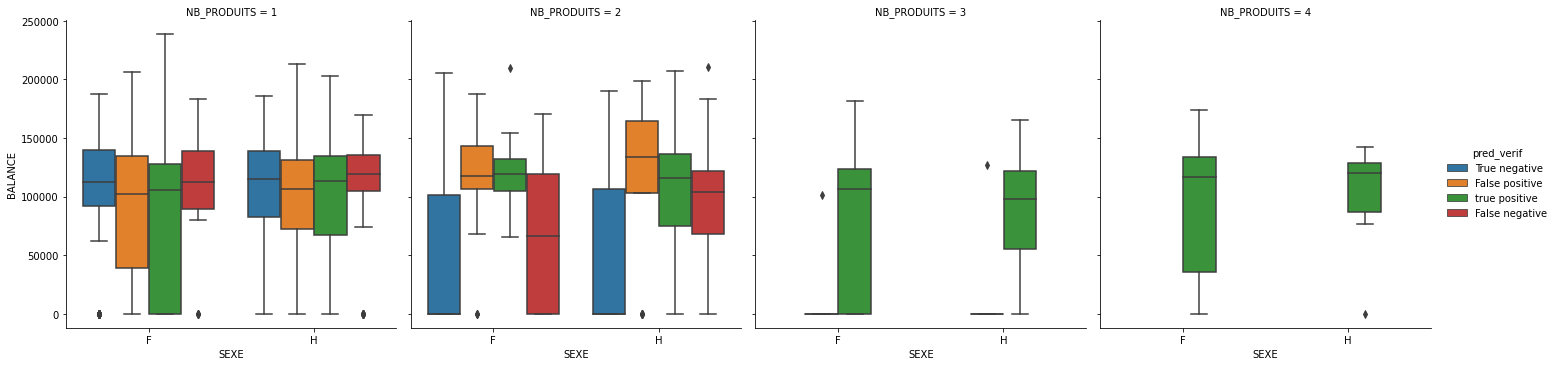

In [67]:
sns.catplot(x="SEXE", y="BALANCE",

                hue="pred_verif", col="NB_PRODUITS",

                data=X_test, kind="box",

                height=5);

Ici, on s'interesse encore aux boites oranges et rouge. On remarque que les clients sont le plus répartis sur le nombre de produits 1 et 2. On remarque ensuite que pour les clients avec un nombre de produits égal à 4, il n'y a que des vrais positifs. On peut donc considérer que le fait d'avoir un nombre de produits égal à 4 est un facteur très déterminant dans le fait de quitter la banque. Pour les clients avec 3 produits. On constate qu'il y a aussi beaucoup de vrais positifs répartis ici et un nombre négligeable de faux positifs. 
Les faux négatifs sont surtout répartis vers les clients qui ont 1 ou 2 produits. Les clients masculins semblent avoir moins de faux positifs, surtout répartis chez les clients qui ont un seul produit. 

## 2.1 Mean Decrease Impurity Importance

On utilise ici l'attribut feature_importances des classifieurs de Sci-kit learn. Ceux-ci calculent pour chaque feature la diminution du critère d'impureté associé au feature. Pour une représentation, on récupère les indices des features qu'on ordonne selon la feature importance. Notre modèle étant composé de plusieurs estimateurs. On peut également calculer un écart type de l'importance d'un feature. 

In [70]:
clf['classifier'].feature_importances_

array([3.33986110e-01, 9.53807765e-02, 2.94798847e-01, 1.44006347e-01,
       7.01447651e-02, 4.60543104e-16, 1.51796141e-03, 2.13088262e-03,
       6.72396085e-03, 2.83523040e-02, 2.29580449e-02])

In [72]:
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
importances = clf['classifier'].feature_importances_
indices = np.argsort(importances)
std = np.std([tree.feature_importances_ for tree in clf['classifier'].estimators_],
             axis=0)

In [73]:
plt.figure()
plt.title("Feature importances")
plt.barh(range(X_test_dummified.shape[1]), importances[indices],
       color="r", xerr=std[indices], align="center")
plt.yticks(range(X_test_dummified.shape[1]), [features[i] for i in indices.tolist()])
plt.ylim([-1, X_test_dummified.shape[1]])
plt.show()

L'age et le nombre de produits semblent être les variables qui diminuent le plus le critère d'impureté. il y a une forte variance de la feature importance entre les estimateurs. 

## 2.2 Mean Decrease Accuracy Importance

On utilise le package eli5 pour créer des réplications de notre base de données au sein desquelles on pratique des permutations aléatoires de valeurs sur une variable. 
On calcule la contribution d'une variable à partir de la différence entre deux loss. La première loss concerne celle du modèle avec le jeu de données d'entraînement. La deuxième loss avec une réplication du jeu de données. L'idée est de mesurer la diminution de la loss qu'on peut imputer à cette variable en considérant le cas où les valeurs liées à cette variables seraient allouées de façon aléatoire de sorte que les valeurs soient indépendantes de la variable cible. 

In [119]:
!pip install eli5

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.

PackagesNotFoundError: The following packages are not available from current channels:

  - eli5

Current channels:

  - https://repo.anaconda.com/pkgs/main/linux-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/linux-64
  - https://repo.anaconda.com/pkgs/r/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




In [75]:
from eli5.sklearn.permutation_importance import PermutationImportance
PermImp = PermutationImportance(clf['classifier'], n_iter=20, random_state=42, cv='prefit', refit=False)

In [76]:
perm = PermImp.fit(X_train_dummified, y_train)

In [77]:
import eli5
eli5.show_weights(perm)

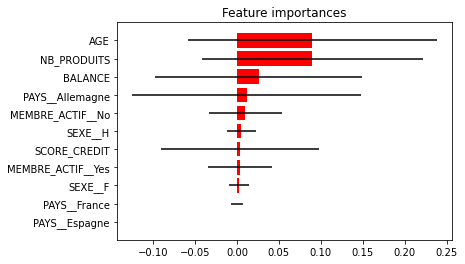

In [78]:
importances = perm.feature_importances_
indices = np.argsort(importances)
std = np.std([tree.feature_importances_ for tree in clf['classifier'].estimators_],
             axis=0)
plt.figure()
plt.title("Feature importances")
plt.barh(range(X_test_dummified.shape[1]), importances[indices],
       color="r", xerr=std[indices], align="center")
plt.yticks(range(X_test_dummified.shape[1]), [features[i] for i in indices.tolist()])
plt.ylim([-1, X_test_dummified.shape[1]])
plt.show()

Le score de crédit semble avoir moins d'importance avec cette méthode, la feature importance gloabale semble être moins élevée et la variance de la feature importance plus élevée entre les estimateurs. 

## 2.3 Partial Dependance Plot

In [41]:
!pip install pdpbox
;

''

In [81]:
from pdpbox import pdp 

In [82]:
variable = 'NB_PRODUITS'
pdp_goals = pdp.pdp_isolate(model=clf['classifier'],
                            dataset=X_test_dummified,
                            model_features=X_test_dummified.columns,
                            feature=variable,
                            num_grid_points=20,
                            grid_type='percentile', 
)

pdp.pdp_plot(pdp_goals, variable, center=True) 
plt.show()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


Le nombre de produits auquel le client souscrit semble d'abord diminuer la valeur prédictive du modèle (sans doute pour NB_PRODUITS = 1), puis avoir un impact positif sur la valeur prédictive. 

## 2.4 ICE curves

In [83]:
from matplotlib.cm import PuOr
from pycebox.ice import ice, ice_plot

In [84]:
X_ref = X_test_dummified.copy().sample(100, random_state=42)

In [85]:
def pred(x):
    return clf['classifier'].predict_proba(x)[:,1]
    

Text(0.5, 1.0, 'ICE Curves')

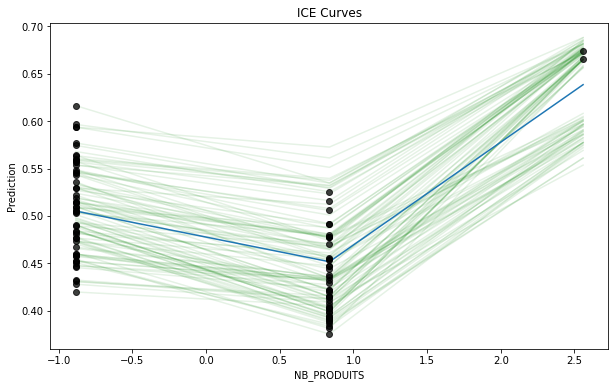

In [86]:
variable = 'NB_PRODUITS' 
f_predict = clf['classifier'].predict_proba
ice_df = ice(X_ref, variable, pred, num_grid_points=20)

fig, ax_ice = plt.subplots(nrows=1, ncols=1,figsize=(10, 6))

ice_plot(ice_df, plot_points=True, point_kwargs={'color': 'k', 'alpha': 0.75}, c='g',
         alpha=0.1, plot_pdp=True, ax=ax_ice)

ax_ice.set_xlabel(variable)
ax_ice.set_ylabel('Prediction') 
ax_ice.set_title('ICE Curves')

## 2.5 Les Valeurs de Shapley

Moyenne des contributions marginales d'une variable à des sous ensembles de variables. Ce que la variable ajoute comme valeur prédictive à un sous-ensemble de variables. Ici, le package shap n'est pas adaptée à la méthode adaboost. Nous allons donc construire un autre classifieur, un random Forrest pour faire ressortir des intérprétations.

In [144]:
import shap
import pandas as pd

In [145]:
shap.initjs()

In [148]:
clf = Pipeline(steps = [('Preprocessor', bench.base_transformer),('Model',RandomForestClassifier(max_features = None,
                                   max_samples=4000, n_estimators=500))])

In [89]:
clf.fit(X_train,y_train);

In [150]:
%%time
explanation = shap.TreeExplainer(clf['Model'])
shap_values = explanation.shap_values(X_test_dummified)[1]
df_contrib = pd.DataFrame(shap_values, columns=X_test_dummified.columns, index=X_test_dummified.index)
bias = explanation.expected_value[1]

CPU times: user 4min 4s, sys: 477 ms, total: 4min 5s
Wall time: 4min 4s


In [151]:
index = 16 # choose an integer
shap.force_plot(explanation.expected_value[1], shap_values[index, :], X_test_dummified.iloc[index, :])

On traite ici à titre d'exemple de l'observation 16 de la base test. Le modèle prédit 0.57 alors que le modèle baseline prédit 0.2021. Les features qui augmentent la valeur prédictive sont en rouge tandis que ceux qui la diminiue sont en bleu. 
L'age et le nombre de produits semblent être les variables avec le plus d'impact sur cette observation.


In [154]:
shap.force_plot(explanation.expected_value[1], shap_values, X_test_dummified)

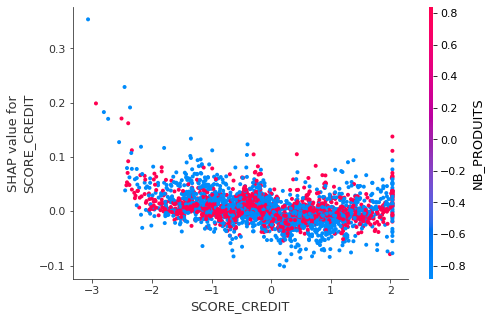

In [155]:
variable_1 = "SCORE_CREDIT"
variable_2 = "NB_PRODUITS"
interaction_index = X_test_dummified.columns.tolist().index(variable_2)

shap.dependence_plot(variable_1, shap_values, X_test_dummified, interaction_index=interaction_index)

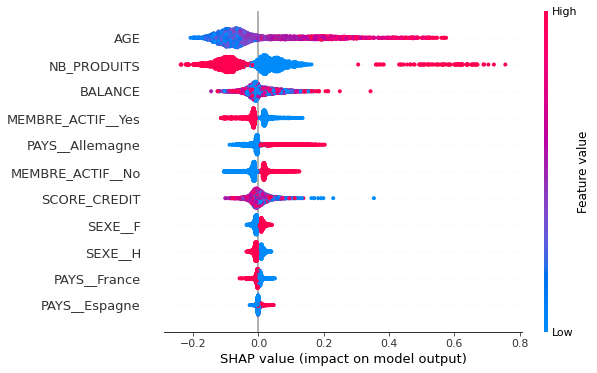

In [156]:
shap.summary_plot(shap_values, X_test_dummified, plot_type="dot")

On voit ici que les variables les plus déterminantes, sont l'age et le nombre de produits souscrit. On peut voir qu'avec ce modèle plus l'âge est important plus la valeur prédictive augmente. ce qui veut dire que les personnes agées ont plus de chance de quitter la banque que les autres. Le nombre de produits a un effet ambigu. En effet, beaucoup de valeurs hautes du nombre de produits sont répartis vers des valeurs de shapley négatives tandis que d'autres sont répartis vers les plus hautes valeurs de shapley.
La solde a également un effet très ambigu.
Pour ce qui est des variables binaires en revanche, l'intérprétation est claire. Le fait d'être membre actif diminue la probabilité de churner. Le fait d'être un client d'Allemagne augmente la probabilité de churner. Le fait dêtre de sexe masculin diminue la probabilité de churner.